<a href="https://colab.research.google.com/github/LCaravaggio/scrapers/blob/master/Google_Earth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install -U seleniumbase
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!sudo dpkg -i google-chrome-stable_current_amd64.deb
!sudo apt-get install -f  # Para resolver dependencias

In [2]:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from seleniumbase import Driver
import time

In [4]:
import pandas as pd
from PIL import Image
ciudades=pd.read_csv('base.csv')

In [5]:
from google.colab import files

def take_image1K(X):
  driver = Driver(uc=True)
  lat=str(ciudades.Latitude[X])
  lon=str(ciudades.Longitude[X])
  # Cargar la página
  url = f"https://earth.google.com/web/@{lat},{lon},20a,76000d,1y,-0h,0t,0r/data=CgRCAggBOgMKATBCAggASg0I____________ARAA"
  driver.get(url)
  start_time = time.time()
  while time.time() - start_time < 120:
      pass
  # Tomar captura de pantalla
  screenshot_name = ciudades.City[X]+" - 1K.png"
  driver.save_screenshot(screenshot_name)

  img = Image.open(screenshot_name)
  width, height = img.size
  crop_top = 200
  crop_bottom = 100
  cropped_img = img.crop((0, crop_top, width, height - crop_bottom))
  cropped_img.save(screenshot_name)

  print(f"Screenshot saved to: {screenshot_name}")
  files.download(screenshot_name)
  driver.quit()

In [6]:
def take_image10K(X):
  driver = Driver(uc=True)
  lat=str(ciudades.Latitude[X])
  lon=str(ciudades.Longitude[X])
  # Cargar la página
  url = f"https://earth.google.com/web/@{lat},{lon},20a,300000d,1y,-0h,0t,0r/data=CgRCAggBOgMKATBCAggASg0I____________ARAA"
  driver.get(url)
  start_time = time.time()
  while time.time() - start_time < 120:
      pass
  # Tomar captura de pantalla
  screenshot_name = ciudades.City[X]+" - 10K.png"
  driver.save_screenshot(screenshot_name)
  img = Image.open(screenshot_name)
  width, height = img.size
  crop_top = 200
  crop_bottom = 100
  cropped_img = img.crop((0, crop_top, width, height - crop_bottom))
  cropped_img.save(screenshot_name)
  print(f"Screenshot saved to: {screenshot_name}")
  files.download(screenshot_name)
  driver.quit()

In [7]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Cargar ResNet-18 preentrenada
resnet18 = models.resnet18(pretrained=True)
resnet18 = torch.nn.Sequential(*list(resnet18.children())[:-1])  # Quitar la capa final de clasificación
resnet18.eval()  # Poner en modo evaluación

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_features(img_path):
    """Extrae features de una imagen usando ResNet-18"""
    img = Image.open(img_path).convert("RGB")
    img = transform(img).unsqueeze(0)  # Añadir batch dimension
    with torch.no_grad():
        features = resnet18(img)
    return features.flatten().numpy()  # Convertir a vector de 512 dimensiones

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


In [8]:
import numpy as np

def compute_inequality(image_1km_path, image_10km_path):
    # Extraer características de ambas imágenes
    features_1km = np.mean(extract_features(image_1km_path))
    features_10km = np.mean(extract_features(image_10km_path))

    # Calcular la diferencia entre ambas medidas de desigualdad
    difference = abs(features_1km - features_10km)

    return {
        "Desigualdad cercana (1km)": features_1km,
        "Desigualdad amplia (10km)": features_10km,
        "Diferencia entre ambas": difference
    }

In [37]:
import pandas as pd
import numpy as np

for i in range(220):  # Iterar sobre los primeros elementos
    lat = ciudades.loc[i, "Latitude"]
    lon = ciudades.loc[i, "Longitude"]
    if pd.isna(ciudades.loc[i, "Diferencia"]):  # Solo procesar si "Diferencia" está vacío
        try:
            take_image1K(i)
        except Exception as e:
            print(f"⚠️ Error en take_image1K para {lat}, {lon}: {e}")

        try:
            take_image10K(i)
        except Exception as e:
            print(f"⚠️ Error en take_image10K para {lat}, {lon}: {e}")

In [38]:
for i in range(220):
  if pd.isna(ciudades.loc[i, "Diferencia"]):  # Solo procesar si "Diferencia" está vacío
    try:
        resultados = compute_inequality(ciudades.City[i] + " - 1K.png",
                                        ciudades.City[i] + " - 10K.png")
        ciudades.loc[i, "Desigualdad_1km"] = resultados["Desigualdad cercana (1km)"]
        ciudades.loc[i, "Desigualdad_10km"] = resultados["Desigualdad amplia (10km)"]
        ciudades.loc[i, "Diferencia"] = resultados["Diferencia entre ambas"]
    except Exception as e:
        print(f"⚠️ Error en compute_inequality para {lat}, {lon}: {e}")

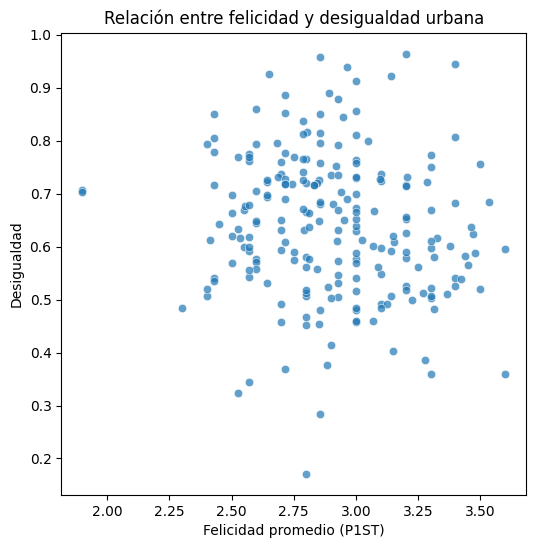

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar el gráfico
plt.figure(figsize=(6,6))
sns.scatterplot(data=ciudades, x="P1ST", y="Desigualdad_1km", alpha=0.7)

# Etiquetas y título
plt.xlabel("Felicidad promedio (P1ST)")
plt.ylabel("Desigualdad")
plt.title("Relación entre felicidad y desigualdad urbana")

# Mostrar el gráfico
plt.show()

In [40]:
import statsmodels.api as sm

# Definir variables
X = ciudades["Desigualdad_1km"].replace([np.inf, -np.inf], np.nan)
y = ciudades["P1ST"].replace([np.inf, -np.inf], np.nan)

# Filtrar filas con NaN en X o y
mask = X.notna() & y.notna()
X, y = X[mask], y[mask]

# Agregar constante para la ordenada al origen
X = sm.add_constant(X)

# Ajustar modelo
modelo = sm.OLS(y, X).fit()

# Resumen de la regresión
print(modelo.summary())


                            OLS Regression Results                            
Dep. Variable:                   P1ST   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     3.727
Date:                Fri, 21 Mar 2025   Prob (F-statistic):             0.0548
Time:                        19:38:32   Log-Likelihood:                -46.763
No. Observations:                 220   AIC:                             97.53
Df Residuals:                     218   BIC:                             104.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.0887      0.099     

In [41]:
import os
from google.colab import files

# Obtener una lista de todos los archivos .png en la carpeta actual
png_files = [f for f in os.listdir() if f.endswith(".png")]

# Descargar cada archivo
for file in png_files:
    files.download(file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
# OJO Borra los archivos PNG

import os
png_files = [f for f in os.listdir() if f.endswith(".png")]

for file in png_files:
    os.remove(file)

In [36]:
ciudades.to_csv('base.csv')
files.download('base.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>